# Assignment 1: System Perspective

In [305]:
import Pkg
Pkg.activate(normpath(joinpath(@__DIR__, ".")))
Pkg.resolve()
Pkg.instantiate()

  Activating project at `c:\Users\lange\OneDrive\Projects\2025\DTUElectricityMarkets2025\assignment1`
  No Changes to `C:\Users\lange\OneDrive\Projects\2025\DTUElectricityMarkets2025\assignment1\Project.toml`
  No Changes to `C:\Users\lange\OneDrive\Projects\2025\DTUElectricityMarkets2025\assignment1\Manifest.toml`
Precompiling project...
   9757.0 ms  ✓ OPF
  1 dependency successfully precompiled in 11 seconds. 311 already precompiled.
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version. Otherwise, loading dependents of this package may trigger further precompilation to work with the unexpected version.


In [306]:
using Revise
using OPF.Utils
using OPF.A1

┌ Error: Failed to revise C:\Users\lange\OneDrive\Projects\2025\DTUElectricityMarkets2025\OPF.jl\src\Utils\Utils.jl
│   exception = (LoadError("C:\\Users\\lange\\OneDrive\\Projects\\2025\\DTUElectricityMarkets2025\\OPF.jl\\src\\Utils\\Utils.jl", 26, UndefVarError(Symbol("@reexport"), OPF.Utils)), Union{Ptr{Nothing}, Base.InterpreterIP}[])
└ @ Revise C:\Users\lange\.julia\packages\Revise\Iwohz\src\packagedef.jl:778
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   C:\Users\lange\OneDrive\Projects\2025\DTUElectricityMarkets2025\OPF.jl\src\Utils\Utils.jl
│ 
│ If the error was due to evaluation order, it can sometimes be resolved by calling `Revise.retry()`.
│ Use Revise.errors() to report errors again. Only the first error in each file is shown.
│ Your prompt color may be yellow until the errors are resolved.
└ @ Revise C:\Users\lange\.julia\packages\Revise\Iwohz\src\packagedef.jl:893


# Preparation

## Market Clearing as an optimization problem
The market operator clears the market by maximizing “social welfare”,
which is the area between the supply and demand curves.

The point where the demand and supply curves intersect is the **market clearing point**, or equilibrium point. At this point demands are happy because they get the energy they want at a price lower or equal to what they were willing to pay, and suppliers are happy because they get the price they want or more for the energy they supply.

The market clearing point is the point where both the **market clearing quantity** and **market clearing price** are determined. It can be found by solving an optimization problem, which is formulated as a simple linear program. 

NB: we consider here uniform pricing, i.e., all suppliers are **paid the same price** for the energy they supply, and all consumers pay the same price for the energy they consume.

$$
\begin{align}
\max_{\mathbf{p}^G, \mathbf{p}^D} \quad & \sum_{i=1}^{N_D} \pi_i^D p_i^D - \sum_{j=1}^{N_G} \pi_j^G p_j^G \\
\text{subject to} \quad & \sum_{j=1}^{N_G} p_j^G - \sum_{i=1}^{N_D} p_i^D = 0 \\
& 0 \leq p_i^D \leq P_i^D, \quad i = 1, \ldots, N_D \\
& 0 \leq p_j^G \leq P_j^G, \quad j = 1, \ldots, N_G
\end{align}
$$

Here:
- $N_D$ is the number of demand nodes
- $N_G$ is the number of generation nodes
- $p_i^D$ is the *elastic* scheduled power demand magnitude at node $i$
- $p_j^G$ is the scheduled power generation magnitude at node $j$
- $\pi_i^D$ is the demand bid price at node $i$
- $\pi_j^G$ is the generation bid price at node $j$
- $P_i^D$ is the maximum demand that can be offered at node $i$
- $P_j^G$ is the maximum generation that can be offered at node $j$

We can also write this as a minimization problem and in vector form:

$$
\begin{align}
\min_{\mathbf{p}^G, \mathbf{p}^D} \quad & \boldsymbol{\pi}^G \cdot \mathbf{p}^G - \boldsymbol{\pi}^D \cdot \mathbf{p}^D \\
\text{subject to} \quad & \mathbf{p}^G - \mathbf{p}^D = 0 \\
& 0 \leq \mathbf{p}^D \leq \mathbf{P}^D \\
& 0 \leq \mathbf{p}^G \leq \mathbf{P}^G
\end{align}
$$

Where $(\cdot)$ is the dot product and $\mathbf{p}^G$ and $\mathbf{p}^D$ are vectors of scheduled power generation and demand, respectively.

The constraint Eq. 2 ensures demand and generation are in balance.
The constraints Eq. 3 and Eq. 4 ensure that the scheduled power demand and generation are kept within their respective limits.

## Data collection and preparation

In order to solve a proper version of this optimization problem we need somewhat realistic pricing, generation and demand data. 

The assignment description is quite vague about data collection and preparation. It provides you some resources, but it does not explain how to use them. It is up to you to figure that out. I suppose from a pedagogical perspective this can either be a good or a bad thing. 

Collecting, curating and preparing data is an important, but time-consuming task in my experience. It doesn't hurt to become acquainted with it right now while you are still in the safety net of your studies. Real data is often (read: always) messy, incomplete, inconsistent and often not even correct! Dealing with this is a skill that you will need in your future career.

In my personal view it is not necessary to get to the core of the assignment, which is about formulating and solving a market clearing problem. The instructors *could* have saved you some time by providing you with a proper dataset, but didn't. So we have to spent some time doing it ourselves. I guess if you worked in a group you could draw straws ;)

I am lazy, so I used our AI overlord to transcribe PDF files to CSV. You can find these under `assignment1/data/`.

## Assumptions

Additionally the following assumptions are made (from the assignement description):

| Assumption | Implication for optimization |
|------------|-------------|
| The production cost of renewable units is assumed to be zero.  | $\pi_j^G = 0$ for all renewable units $j$ |
| Reneweable units offer their forecasted capacity, meaning their offer quantities vary over time. | $P_j^G$ is time-dependent for all renewable units $j$ (so $P_{j,t}^G$)|


## Generate demand data

The data is provided in the `assignment1/data/` folder. This data is in CSV format, which we will read into a DataFrame.


In [307]:
hours = 0:23

0:23

In [308]:
demands = prepare_demands(hours; save=true)
first(demands, 5)

Row,1,2,3,4,5,6,7,8,9,10,13,14,15,16,18,19,20
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,44.7726,39.4751,73.9784,27.1306,30.4113,54.634,54.8351,67.7929,72.5925,77.5301,104.365,80.5276,130.453,40.5283,134.459,75.6561,60.2701
2,41.2923,40.4595,78.1231,29.8886,29.4132,62.3305,55.0981,69.9339,75.9539,83.2412,100.482,76.4079,136.699,41.4827,138.696,75.2979,56.4138
3,45.6887,38.6716,69.567,30.7328,28.8733,57.9311,50.0617,68.7621,69.1433,80.1722,103.483,86.229,147.624,37.205,145.274,81.8477,51.9461
4,45.4582,39.9823,74.3261,30.3192,31.2153,60.4052,48.6228,73.0599,74.5794,84.0916,114.191,77.9663,125.437,40.3912,168.807,87.1636,54.9816
5,49.5185,44.5522,82.1604,35.0284,30.476,64.39,53.6535,80.6432,72.8181,84.4297,108.549,81.9368,145.397,46.9999,146.196,78.4639,59.8051


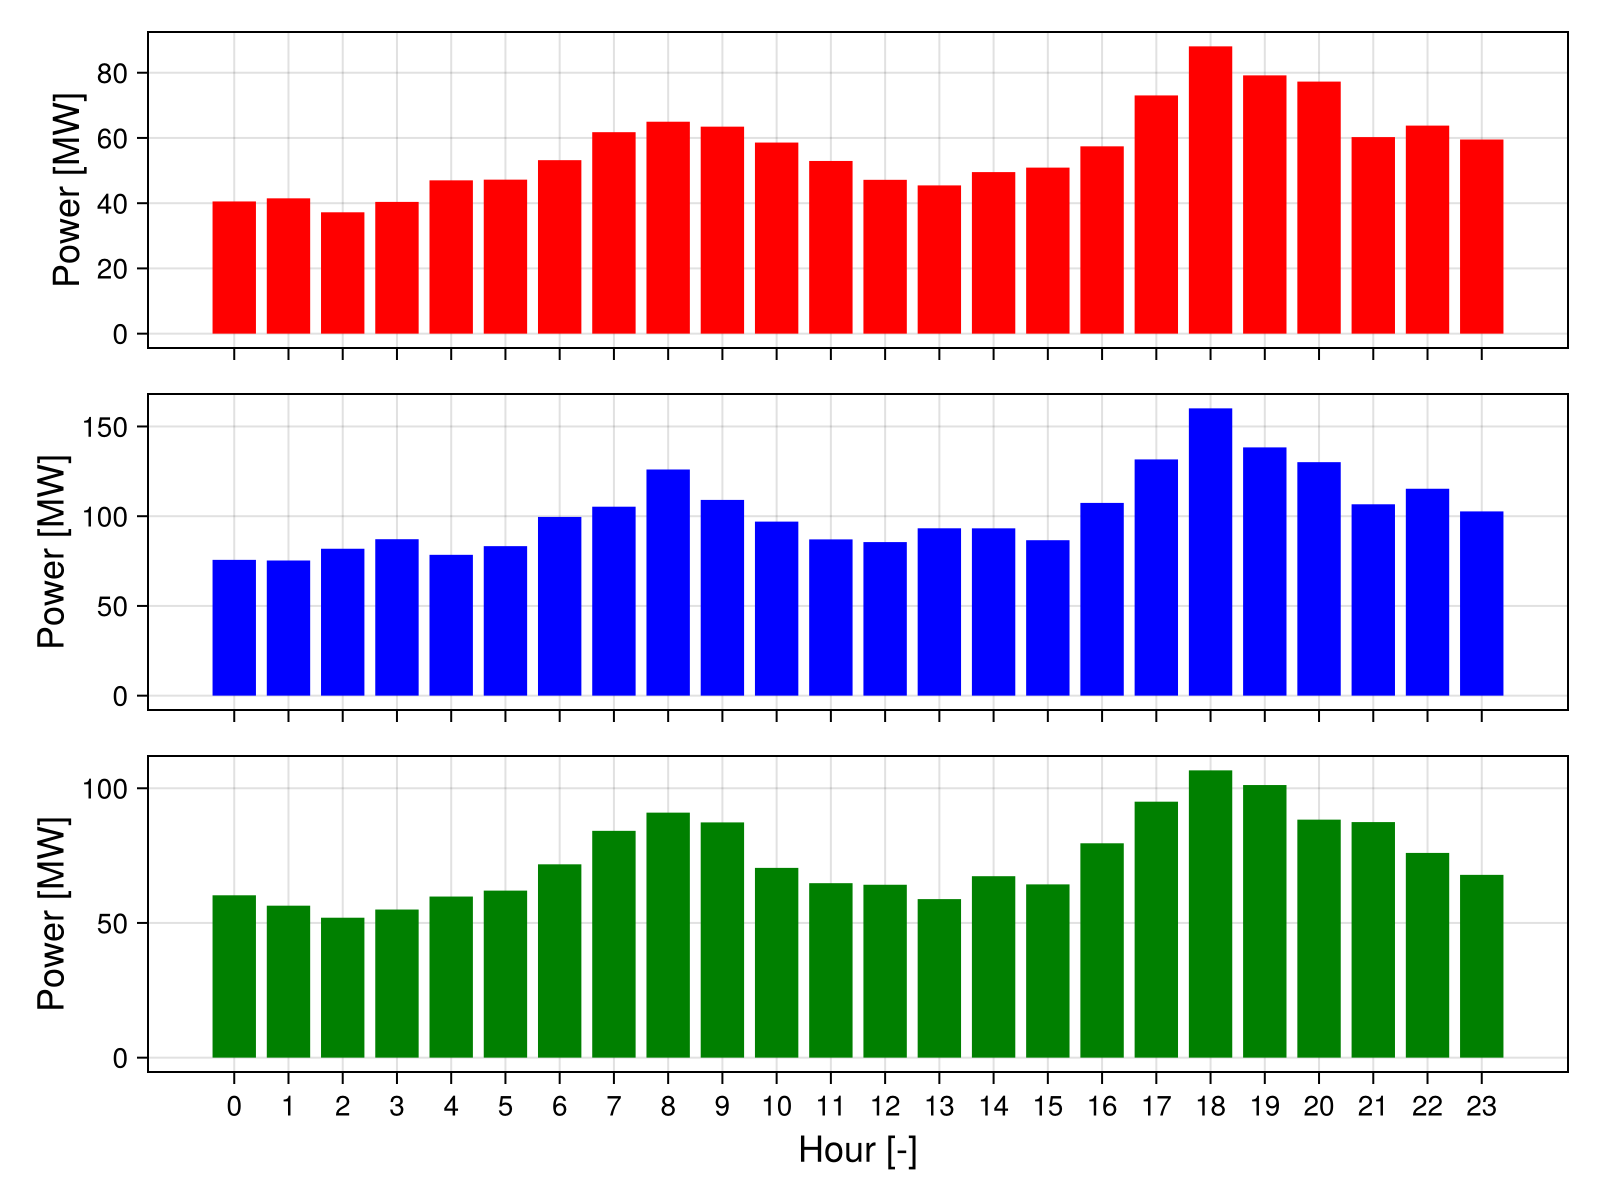

In [309]:
plot_powers(demands[:, Symbol.([16,19,20])]; colors=[:red, :blue,:green])

### Generate generation data

In [310]:
generation_fixed = prepare_generation_fixed()

Row,id,bus,production_cost_D_MWh,upreservecost_D_MW,downreservecost_D_MW,capacity_MW,maxupreserve_MW,maxdownreserve_MW
,Int64,Int64,Float64,Float64,Float64,Float64,Int64,Int64
1,1,1,13.32,1.68,2.32,106.4,48,48
2,2,2,13.32,1.68,2.32,106.4,48,48
3,3,7,20.7,3.3,4.67,245.0,84,84
4,4,13,20.93,4.07,3.93,413.7,216,216
5,5,15,26.11,1.89,3.11,42.0,42,42
6,6,15,10.52,5.48,3.52,108.5,36,36
7,7,16,10.52,5.48,3.52,108.5,36,36
8,8,18,6.02,4.98,5.02,280.0,60,60
9,9,21,5.47,5.53,4.97,280.0,60,60


In [311]:
generation_wind = prepare_generation_wind(hours.+18; save=true)
first(generation_wind, 5)

Row,3,5,16,21
,Float64,Float64,Float64,Float64
1,413.891,322.233,234.399,279.139
2,399.948,400.969,244.623,260.17
3,409.179,369.033,251.093,253.39
4,411.056,385.943,255.519,263.077
5,419.89,355.359,235.908,281.442


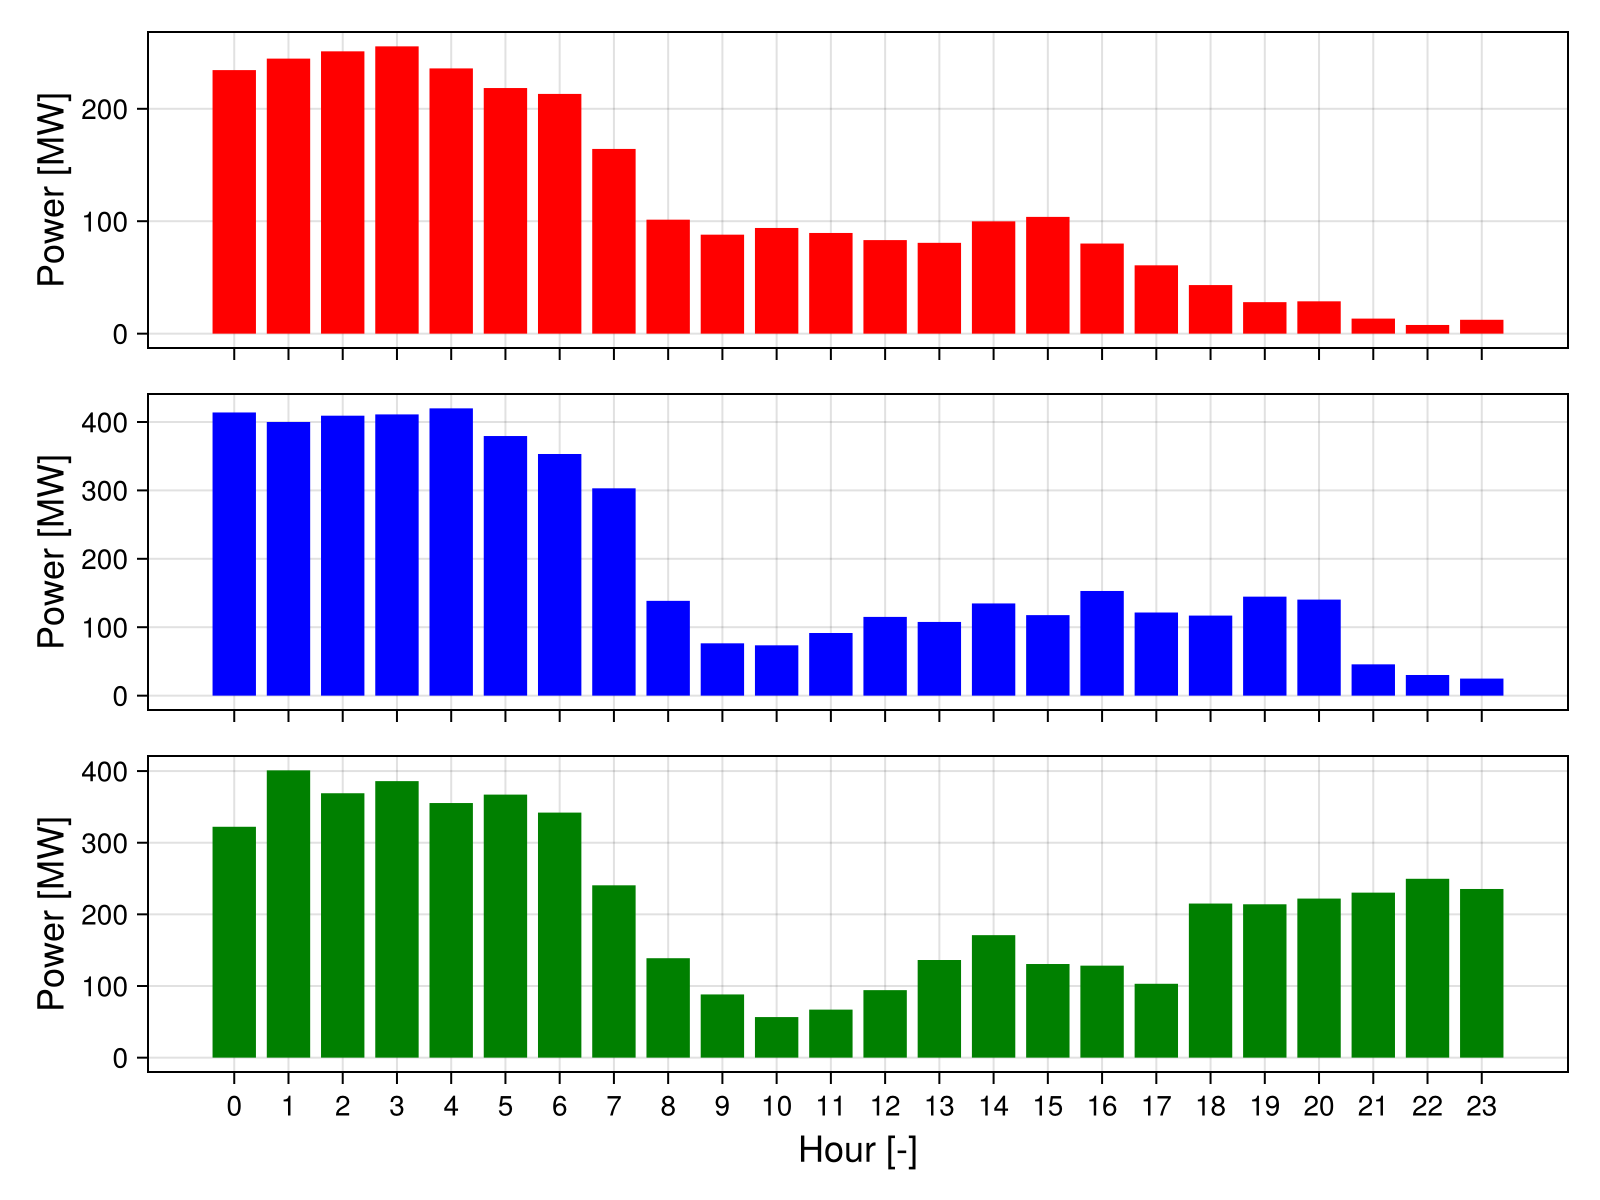

In [312]:
plot_powers(generation_wind[:, Symbol.([16,3,5])]; colors=[:red, :blue,:green])

## Generate demand price data

For the bid price of price-elastic demands, use comparatively high values (relative to the
generation cost of conventional units) to ensure that most demands are supplied. For
inspiration, check the real bid price data in Nord Pool.

The fixed generators have a maximum generator price of around 30 EUR/MWh. The price of the
demands should therefore be around 100 EUR/MWh.

In [326]:
demand_prices = prepare_demand_pricing(parse.(Int, names(demands)))
first(demand_prices, 5)

Row,bus,price
,Int64,Float64
1,1,33.2352
2,2,10.9769
3,3,31.5374
4,4,24.7137
5,5,37.2592


## Load network data

In [327]:
network = prepare_network()
first(network, 5)

Row,from_bus,to_bus,susceptance_pu,capacity_MW
,Int64,Int64,Float64,Int64
1,1,2,0.0146,175
2,1,3,0.2253,175
3,1,5,0.0907,350
4,2,4,0.1356,175
5,2,6,0.205,175


## Step 1: Copper plate, single hour

This is a very basic market clearing problem. We just need some load, generation and price data for a single hour.

We have already prepared the data, so all we need to do is to load it and run the optimization problem.

### KKT conditions of clearing a single hour market

The problem in standard form can be written as:
$$
\begin{align}
\min_{\mathbf{p}^G, \mathbf{p}^D} \quad & (\boldsymbol{\pi}^G)^T \mathbf{p}^G - (\boldsymbol{\pi}^D)^T \mathbf{p}^D \\
\text{s.t.} \quad & \mathbf{p}^G - \mathbf{p}^D = 0 \quad : \quad \lambda \\
-\mathbf{p}^D & \leq 0 \quad : \quad \underline{\boldsymbol{\mu}}^D \\
\mathbf{p}^D - \mathbf{P}^D & \leq 0 \quad : \quad \overline{\boldsymbol{\mu}}^D \\
-\mathbf{p}^G & \leq 0 \quad : \quad \underline{\boldsymbol{\mu}}^G \\
\mathbf{p}^G - \mathbf{P}^G& \leq 0 \quad : \quad \overline{\boldsymbol{\mu}}^G
\end{align}
$$

We collect $\boldsymbol{\mu} = [\underline{\boldsymbol{\mu}}^D, \overline{\boldsymbol{\mu}}^D, \underline{\boldsymbol{\mu}}^G, \overline{\boldsymbol{\mu}}^G]$ and $\lambda$ as the Lagrange multipliers, and
$\mathbf{x} = [\mathbf{p}^G, \mathbf{p}^D]$ as the decision variables.

The Lagrangian is given by:
$$
\begin{align}
\mathcal{L}(\mathbf{x}, \lambda, \boldsymbol{\mu}) = f(\mathbf{x}) + \lambda \cdot g(\mathbf{x}) + \boldsymbol{\mu}^T h(\mathbf{x})
\end{align}
$$

Where: 
- $\mathbf{x} = (\mathbf{p}^G, \mathbf{p}^D)$ is the vector of decision variables
- $f(\mathbf{x}) = \boldsymbol{\pi}^G \cdot p^G - \boldsymbol{\pi}^D \cdot p^D$ is the objective function
- $g(\mathbf{x}) = \mathbf{p}^G - \mathbf{p}^D$ is the single equality constraint for system balance
- $h(\mathbf{x})$ is the vector of inequality constraints:
$$
h(\mathbf{x}) = \begin{bmatrix}
-\mathbf{p}^D \\
\mathbf{p}^D - \mathbf{P}^D \\
-\mathbf{p}^G \\
\mathbf{p}^G - \mathbf{P}^G
\end{bmatrix}
$$

The KKT conditions for this problem are given by:
$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial \mathbf{x}} &= 0 \quad \text{(stationarity)} \\
h(\mathbf{x}) &= 0 \quad \text{(primal feasibility)} \\
\lambda \cdot g(\mathbf{x}) &= 0 \quad \text{(complementary slackness)} \\
\boldsymbol{\mu}^T h(\mathbf{x}) &= 0 \quad \text{(dual feasibility)} \\
\boldsymbol{\mu} &\geq 0 \quad \text{(dual feasibility)} \\
\lambda &\in \mathbb{R} \quad \text{(unrestricted)}
\end{align}
$$


### Merit order and demand curve

Before we start, lets plot the merit order and demand curve.

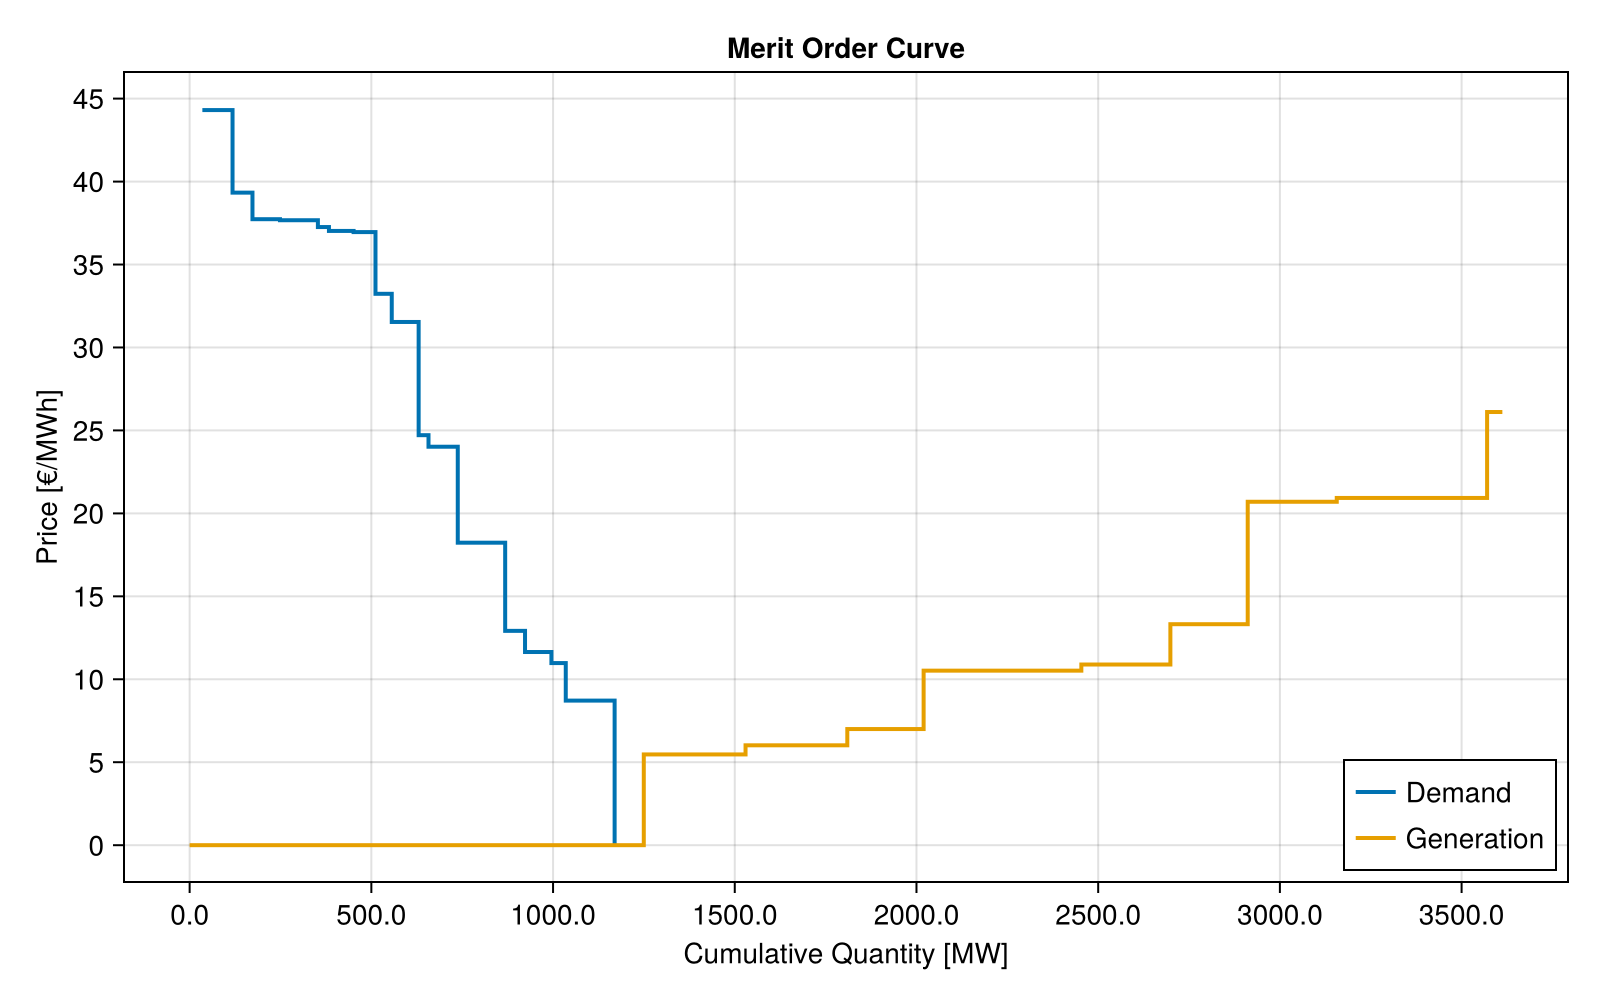

In [328]:
hour = 1

demand_cost = Dict(demand_prices.bus .=> demand_prices.price)
generation_cost = Dict(generation_fixed.bus .=> generation_fixed.production_cost_D_MWh)

# `demand_bids`: Vector of (quantity, price) tuples for demand (unsorted).
demand_bids = [(demand, price) for (demand, price) in zip(demands[hour, :], demand_prices.price)]

# `generation_bids`: Vector of (quantity, price) tuples for generation (unsorted).
generation_bids = [(generation, price) for (generation, price) in zip(generation_fixed.capacity_MW, generation_fixed.production_cost_D_MWh)]
generation_bids = vcat(generation_bids, [(generation, 0.0) for generation in generation_wind[hour, :]])

fig = plot_merit_order(demand_bids, generation_bids)

### Copper plate with only one hour market clearing

In [329]:
model, results = market_clearing(1:1; 
    generation_wind=generation_wind, 
    generation_fixed=generation_fixed, 
    demands=demands, 
    network=network,
    demand_prices=demand_prices,
)
results[:system]

Row,CP,SW,P_G_total,P_D_total
,Float64,Float64,Float64,Float64
1,-0.0,32008.0,1169.41,1169.41


# Step 2: Copper-Plate, Multiple Hours

## Without storage

In [330]:
model, results = market_clearing(1:24; 
    generation_wind=generation_wind, 
    generation_fixed=generation_fixed, 
    demands=demands, 
    network=network,
    demand_prices=demand_prices,
    storage=false,
)
@info "Total social welfare without storage: $(sum(results[:system].SW))"

┌ Info: Total social welfare without storage: 922083.8888168007
└ @ Main c:\Users\lange\OneDrive\Projects\2025\DTUElectricityMarkets2025\assignment1\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X53sZmlsZQ==.jl:9


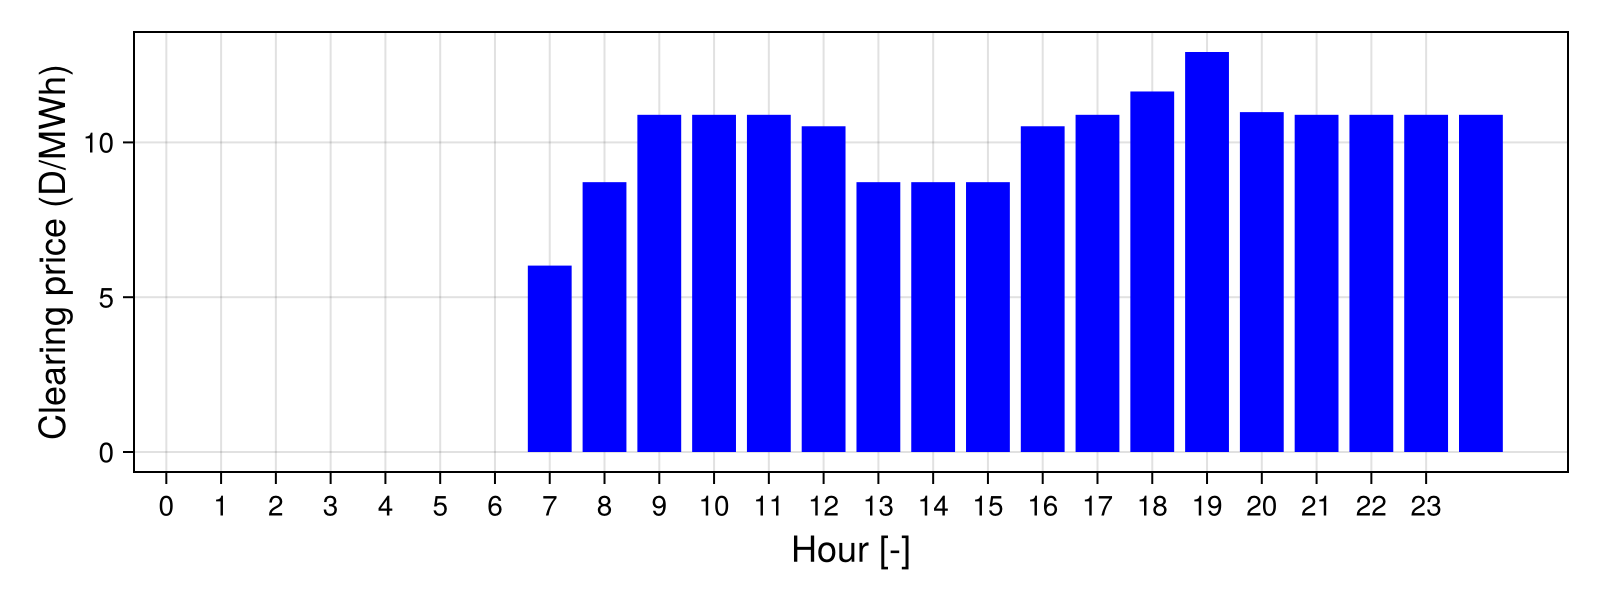

In [331]:
plot_value(model, :CP; ylabel="Clearing price (D/MWh)")

## With storage

Specifications of pumped hydro storage: [Technical Review of Existing Norwegian Pumped Storage Plants](https://www.mdpi.com/1996-1073/13/18/4918)

We will assume the following parameters for the storage:

| Parameter | Value |
|-----------|-------|
| P_ch_max | 200.0 MW |
| P_dis_max | 200.0 MW |
| E_cap | 1000.0 MWh |
| E0 | 0.0 MWh |
| η_ch | 0.90 |
| η_dis | 0.92 |

In [332]:
model_s, results = market_clearing(1:24; 
    generation_wind=generation_wind, 
    generation_fixed=generation_fixed, 
    demands=demands, 
    network=network,
    demand_prices=demand_prices,
    storage=true,
)
@info "Total social welfare with storage: $(sum(results[:system].SW))"

┌ Info: Total profit from storage: 10036.170924539503
└ @ OPF.A1 C:\Users\lange\OneDrive\Projects\2025\DTUElectricityMarkets2025\OPF.jl\src\A1\model.jl:193
┌ Info: Total social welfare with storage: 932283.9610301869
└ @ Main c:\Users\lange\OneDrive\Projects\2025\DTUElectricityMarkets2025\assignment1\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X62sZmlsZQ==.jl:9


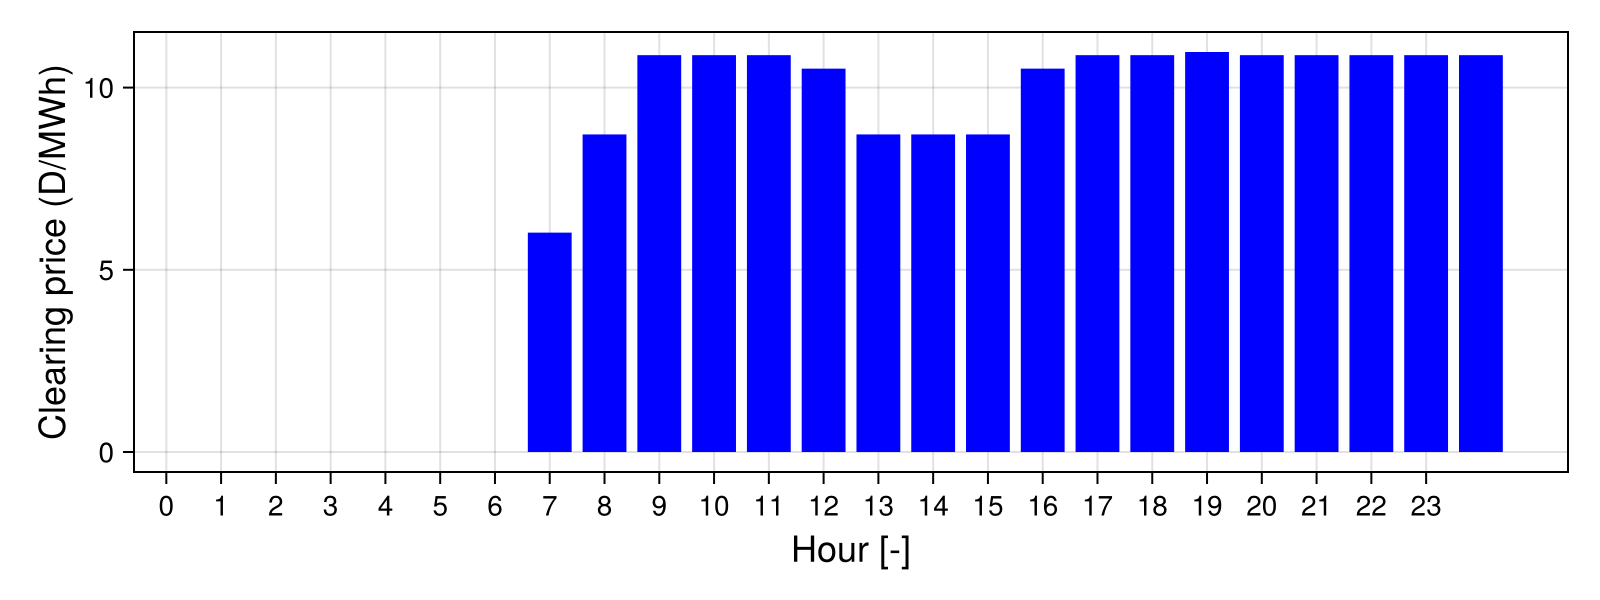

In [333]:
plot_value(model_s, :CP; ylabel="Clearing price (D/MWh)")

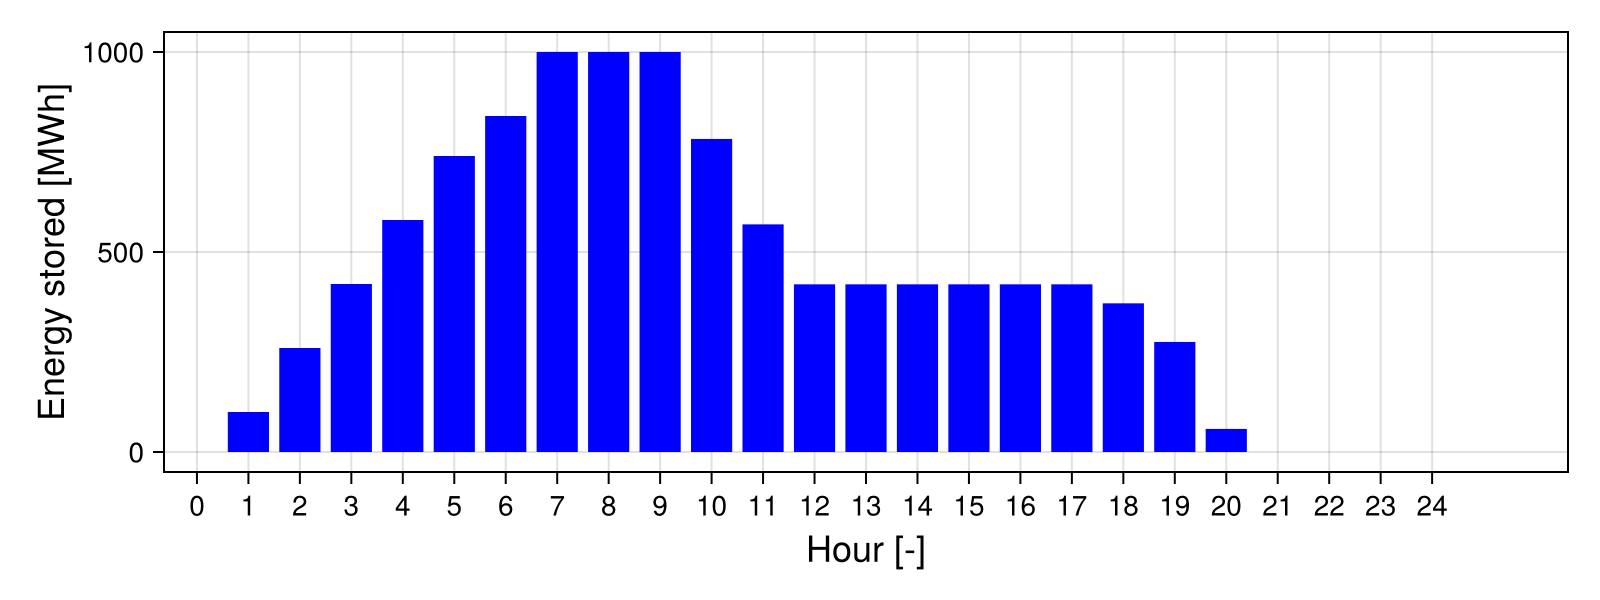

In [334]:
plot_value(model_s, :E; ylabel="Energy stored [MWh]")

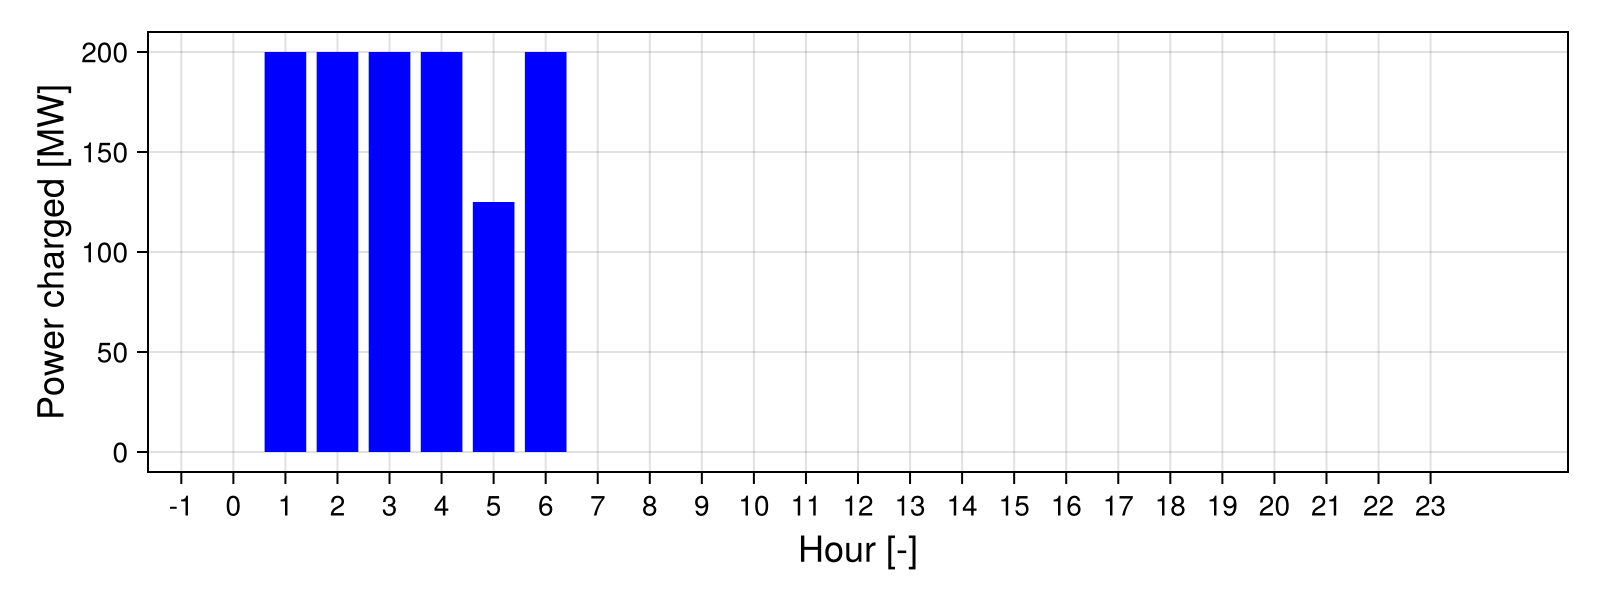

In [335]:
plot_value(model_s, :P_ch; ylabel="Power charged [MW]", offset=-1)

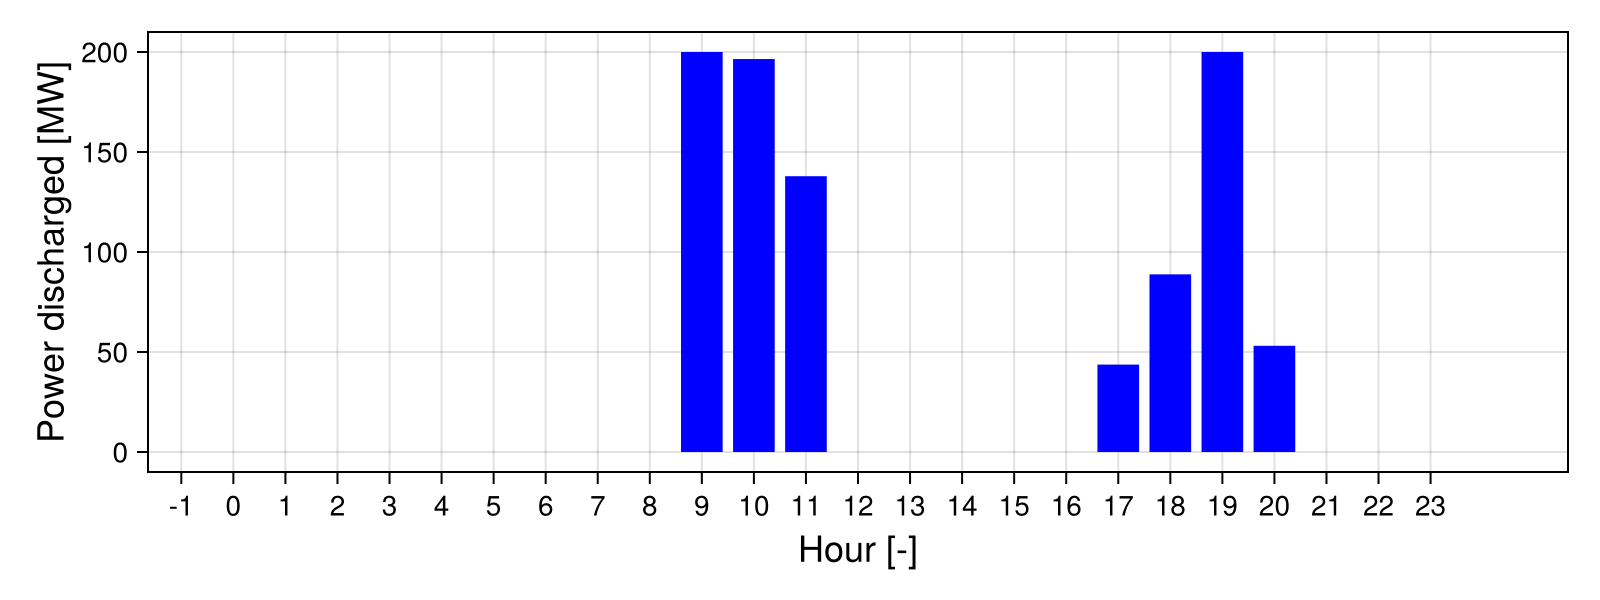

In [336]:
plot_value(model_s, :P_dis; ylabel="Power discharged [MW]", offset=-1)

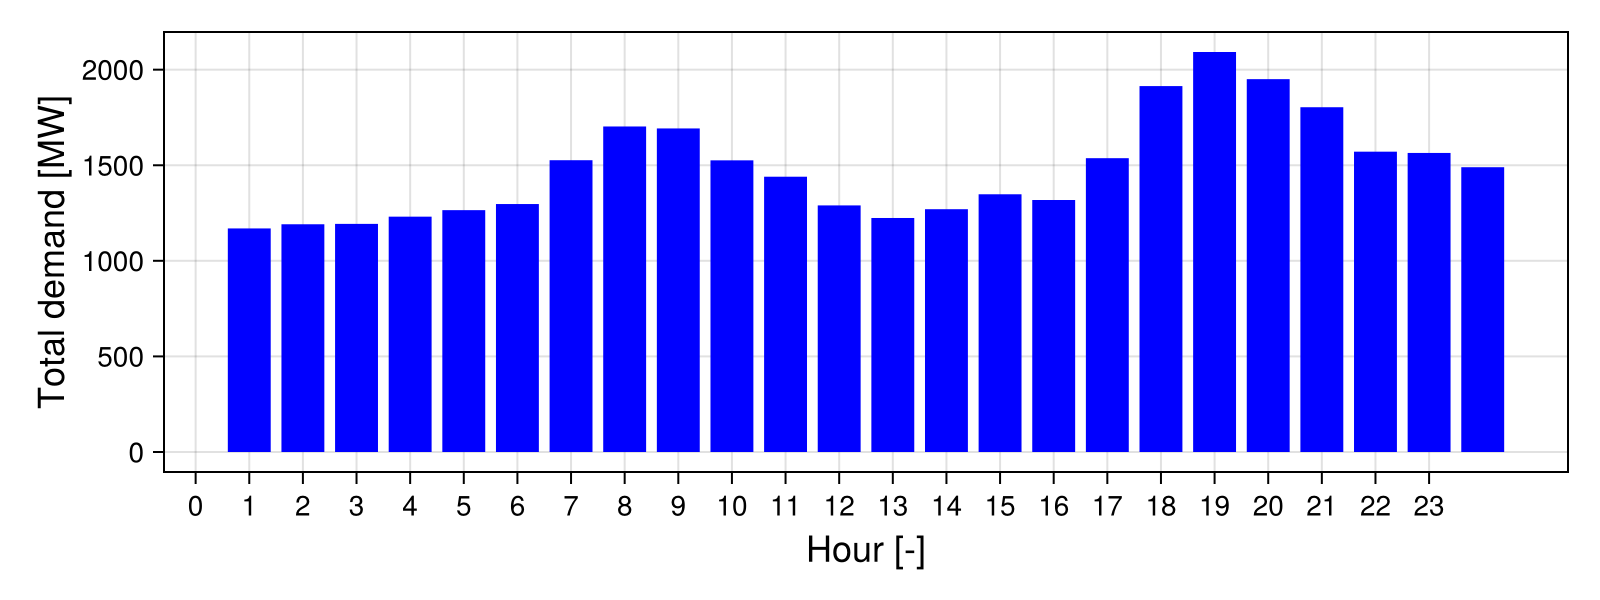

In [337]:
plot_value(results[:system].P_D_total; ylabel="Total demand [MW]", offset=0)

In [ ]:
dCP = value.(model_s[:CP]) .- value.(model[:CP])
for (i, hour) in enumerate(1:24)
    println("Hour $(hour): ΔCP = $(dCP[i]) D/MWh")
end

Hour 1: ΔCP = 0.0 D/MWh
Hour 2: ΔCP = 0.0 D/MWh
Hour 3: ΔCP = 0.0 D/MWh
Hour 4: ΔCP = 0.0 D/MWh
Hour 5: ΔCP = 0.0 D/MWh
Hour 6: ΔCP = 0.0 D/MWh
Hour 7: ΔCP = 0.0 D/MWh
Hour 8: ΔCP = 0.0 D/MWh
Hour 9: ΔCP = 0.0 D/MWh
Hour 10: ΔCP = 0.0 D/MWh
Hour 11: ΔCP = 0.0 D/MWh
Hour 12: ΔCP = 0.0 D/MWh
Hour 13: ΔCP = 0.0 D/MWh
Hour 14: ΔCP = 0.0 D/MWh
Hour 15: ΔCP = 0.0 D/MWh
Hour 16: ΔCP = 0.0 D/MWh
Hour 17: ΔCP = 0.0 D/MWh
Hour 18: ΔCP = -0.7536511454412853 D/MWh
Hour 19: ΔCP = -1.9418430334300645 D/MWh
Hour 20: ΔCP = -0.08685462269750133 D/MWh
Hour 21: ΔCP = 0.0 D/MWh
Hour 22: ΔCP = 0.0 D/MWh
Hour 23: ΔCP = 0.0 D/MWh
Hour 24: ΔCP = 0.0 D/MWh
